**Content**


This dataset comprises of various house listings in London and neighbouring region. It also encompasses the parameters listed below, the definitions of which are quite self-explanatory.


**Colomns meanings**

Property_Name: Name of the property in the listings

Price_in_Pounds: Price of the property in Pounds (£)

House_Type: Contains one of the following types of houses (House, Flat/Apartment, New Development, Duplex, Penthouse, Studio, Bungalow, Mews)
Area_in_feets: Area of the property in
(ft)2

No_of_Bedrooms: Number of bedrooms in House

No_of_Bathrooms: Number of bathrooms in House

No_of_Receptions: Number of receptions in House

Location: Area in which the House is located

City_County: Includes London, Essex, Middlesex, Hertfordshire, Kent, and Surrey.

Postal_Code: Postal code of the house

House_Type_Int: House_Type but in numbers

Address: Address of the house that includes: City_County, Location, Property_Name and Postal Code

# **Data import**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')
import os
import json
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
%matplotlib inline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [2]:
! pip install optuna
import optuna
import plotly
from optuna.visualization import (
    plot_optimization_history,
    plot_edf,
    plot_param_importances,
    plot_parallel_coordinate,
    plot_slice,
    plot_contour
)

In [3]:
import kagglehub
path = kagglehub.dataset_download("arnavkulkarni/housing-prices-in-london")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/housing-prices-in-london


In [4]:
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        filepath = os.path.join(dirname, filename)
        print(f"Найден файл: {filepath}")
        if filename.endswith('.csv'):
            import pandas as pd
            try:
                df = pd.read_csv(filepath)
                print(f"  → Загружен DataFrame: {df.shape}")
            except Exception as e:
                print(f"  → Ошибка загрузки: {e}")

Найден файл: /kaggle/input/housing-prices-in-london/London.csv
  → Загружен DataFrame: (3480, 11)


In [5]:
df.sample(10)

,Unnamed: 0,Property Name,Price,House Type,Area in sq ft,No. of Bedrooms,No. of Bathrooms,No. of Receptions,Location,City/County,Postal Code
1275,1275,Circle Gardens,825000,House,1388,3,3,3,Wimbledon,London,SW19 3JU
316,316,St. Peters Square,2950000,House,3597,4,4,4,NaN,London,W6 9AJ
2245,2245,Brodrick Road,2150000,House,2598,5,5,5,Wandsworth,London,SW17 7DX
2391,2391,Callcott Street,2300000,House,1433,3,3,3,NaN,London,W8 7SU
2289,2289,Cumberland Street,2750000,House,2738,5,5,5,NaN,London,SW1V 4LZ
818,818,Aslett Street,750000,Duplex,1522,4,4,4,NaN,London,SW18 2BQ
1647,1647,Waverley Court,900000,Flat / Apartment,650,2,2,2,34-37 Beaumont Street,Marylebone,W1G 6DH
2399,2399,Park View Road,2750000,House,3558,7,7,7,NaN,London,W5 2JB
284,284,Overstrand Mansions,1800000,Flat / Apartment,1453,3,3,3,Prince of Wales Drive,London,SW11 4HA
1618,1618,Greystoke Gardens,400000,Flat / Apartment,764,2,2,2,Hanger Lane,London,W5 1EP


In [6]:
df.rename(columns={
    'Area in sq ft': 'Area_in_sq_ft',
    'No. of Bedrooms': 'Bedrooms',
    'No. of Bathrooms': 'Bathrooms',
    'No. of Receptions': 'Receptions'
}, inplace=True)

df.head()

,Unnamed: 0,Property Name,Price,House Type,Area_in_sq_ft,Bedrooms,Bathrooms,Receptions,Location,City/County,Postal Code
0,0,Queens Road,1675000,House,2716,5,5,5,Wimbledon,London,SW19 8NY
1,1,Seward Street,650000,Flat / Apartment,814,2,2,2,Clerkenwell,London,EC1V 3PA
2,2,Hotham Road,735000,Flat / Apartment,761,2,2,2,Putney,London,SW15 1QL
3,3,Festing Road,1765000,House,1986,4,4,4,Putney,London,SW15 1LP
4,4,Spencer Walk,675000,Flat / Apartment,700,2,2,2,Putney,London,SW15 1PL


In [7]:
df.drop(columns = 'Unnamed: 0', inplace=True)

In [8]:
df.dtypes

Property Name    object
Price             int64
House Type       object
Area_in_sq_ft     int64
Bedrooms          int64
Bathrooms         int64
Receptions        int64
Location         object
City/County      object
Postal Code      object
dtype: object

In [9]:
df.shape

(3480, 10)

In [10]:
df.describe()

,Price,Area_in_sq_ft,Bedrooms,Bathrooms,Receptions
count,3.480000e+03,3480.000000,3480.000000,3480.000000,3480.000000
mean,1.864173e+06,1712.973563,3.103736,3.103736,3.103736
std,2.267283e+06,1364.259351,1.517698,1.517698,1.517698
min,1.800000e+05,274.000000,0.000000,0.000000,0.000000
25%,7.500000e+05,834.000000,2.000000,2.000000,2.000000
50%,1.220000e+06,1310.000000,3.000000,3.000000,3.000000
75%,2.150000e+06,2157.250000,4.000000,4.000000,4.000000
max,3.975000e+07,15405.000000,10.000000,10.000000,10.000000


In [11]:
df.isnull().sum()
# null values

Property Name      0
Price              0
House Type         0
Area_in_sq_ft      0
Bedrooms           0
Bathrooms          0
Receptions         0
Location         962
City/County        0
Postal Code        0
dtype: int64

# **Feature Analysis**

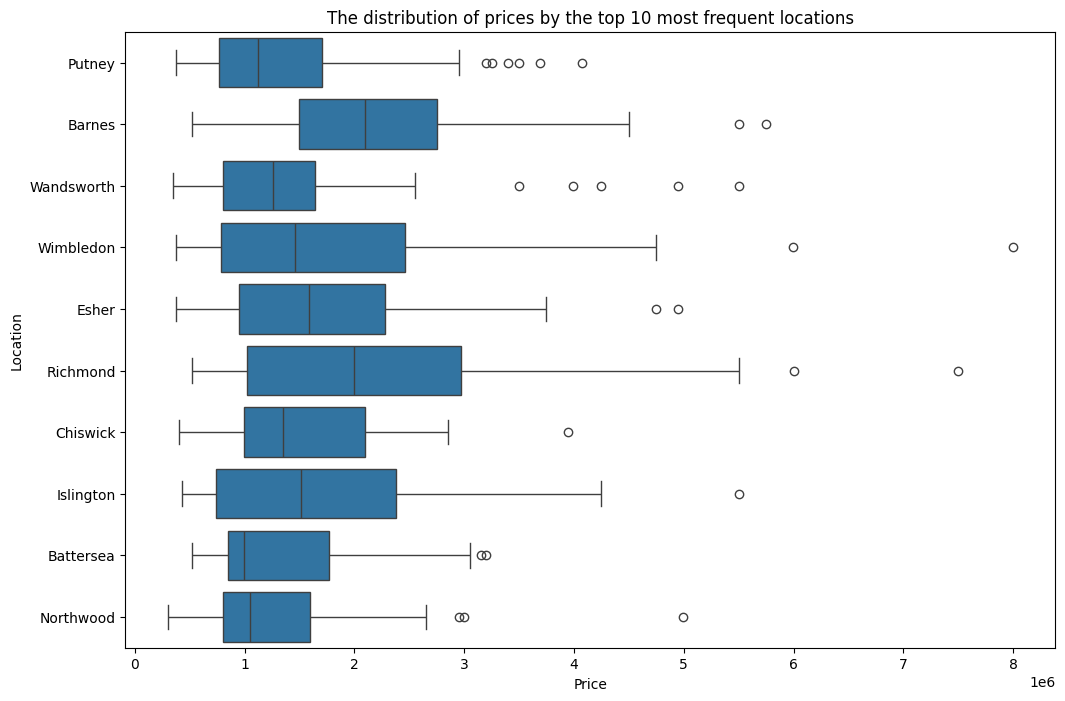

In [12]:
# top-10 the most famous locations
top_10_locations = df['Location'].value_counts().head(10).index
plt.figure(figsize=(12, 8))
sns.boxplot(data=df, x='Price', y='Location', order=top_10_locations)
plt.title('The distribution of prices by the top 10 most frequent locations')
plt.show()

In [13]:
df = df.dropna()

In [14]:
df['Location'] = df['Location'].fillna('Unknown')

In [15]:
df['Area_in_sq_ft'].describe()

count     2518.000000
mean      1766.850278
std       1469.490065
min        274.000000
25%        840.000000
50%       1311.500000
75%       2219.000000
max      15405.000000
Name: Area_in_sq_ft, dtype: float64

In [16]:
#df['price_per_sqft'] = df['Price']/df['Area_in_sq_ft']
#df['price_per_sqft'].describe()

# **Numerical and Categorical Variables**

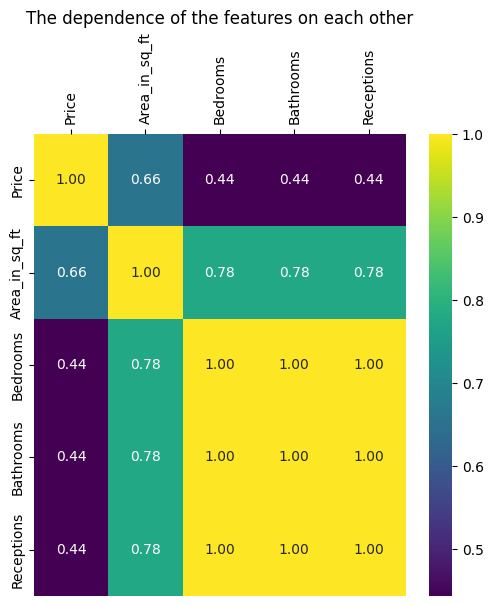

In [17]:
plt.figure(figsize=(6,6))
plt.title('The dependence of the features on each other')

numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
numeric_df = df[numeric_columns]

# heatmap
g = sns.heatmap(data=numeric_df.corr(), annot=True, cmap='viridis', fmt='.2f')
g.xaxis.set_ticks_position('top')
g.xaxis.set_tick_params(rotation=90)
plt.show()

In [18]:
import seaborn as sns
df_num = df.select_dtypes(include=['number'])
correlation = df_num.corr()['Price'].sort_values(ascending=False).to_frame().head()

cmap = sns.color_palette("magma", as_cmap=True)
n = correlation.style.background_gradient(cmap=cmap)
n

,Price
Price,1.000000
Area_in_sq_ft,0.657285
Bedrooms,0.444013
Bathrooms,0.444013
Receptions,0.444013


# **Encoding**

In [19]:
import numpy as np
import random
seed = 42
np.random.seed(seed)
random.seed(seed)

In [20]:
# Проверяю все ли значения в колонках Bedrooms, Bathroom, Receptions одинаковые. (Они, оказались одинаковы)
print((df['Bedrooms'] == df['Bathrooms']).all())
print((df['Bedrooms'] == df['Receptions']).all())

True
True


In [21]:
# попробую избавиться от мультиколлинеарности, возьму среднее от всех комнат
df['all_rooms'] = df[['Bedrooms', 'Bathrooms', 'Receptions']].mean(axis=1)
df.sample()

,Property Name,Price,House Type,Area_in_sq_ft,Bedrooms,Bathrooms,Receptions,Location,City/County,Postal Code,all_rooms
3098,North Gate,3500000,Flat / Apartment,2423,4,4,4,St. John's Wood,London,NW8 7EJ,4.0


In [22]:
df.drop(['Bedrooms', 'Bathrooms', 'Receptions'], axis=1, inplace=True)

In [23]:
df.drop('Postal Code', axis=1, inplace=True)

# **XGBoost regression**

In [24]:
import xgboost as xgb

In [25]:
df.sample(10)

,Property Name,Price,House Type,Area_in_sq_ft,Location,City/County,all_rooms
2748,Dorland Court,525000,Flat / Apartment,654,Putney,London,2.0
898,Edna Street,1735000,House,2144,Battersea,London,4.0
1869,The Drive,1400000,Bungalow,2921,Uxbridge,Middlesex,4.0
3011,Gore Road,405000,Flat / Apartment,376,South Hackney,London,1.0
154,Mare Street,260000,Studio,381,Hackney,London,0.0
53,"The oTTo, Hackney",490000,New development,570,Downs Road,Clapton,1.0
2334,Willow Bridge Road,1750000,Flat / Apartment,1203,Islington,London,3.0
1560,Highbury Hill,999950,Flat / Apartment,840,Highbury,London,2.0
3306,Ikins House,23950000,New development,15405,Hampstead Heath,London,7.0
2827,Eltham Court,575000,New development,800,West Ealing,London,2.0


In [26]:
imputer = SimpleImputer(strategy='most_frequent')
df['Location'] = imputer.fit_transform(df[['Location']]).flatten()

In [27]:
scaler =  RobustScaler(with_centering=True)
one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=True)

In [28]:
X = df.drop('Price', axis=1)
y = df['Price']

In [29]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2,random_state=42, shuffle=True)

In [30]:
y_train_log = np.log1p(y_train)
y_valid_log = np.log1p(y_valid)

In [31]:
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
object_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

print("Числовые колонки:", numerical_cols)
print("Категориальные колонки:", object_cols)

Числовые колонки: ['Area_in_sq_ft', 'all_rooms']
Категориальные колонки: ['Property Name', 'House Type', 'Location', 'City/County']


In [32]:
categorical_features = Pipeline(steps=[
    ('imputer', imputer),
    ('ohe', one_hot_encoder)])

numerical_features = Pipeline(steps=[
    ('scaler', RobustScaler(with_centering=True))])

columnTransformer = ColumnTransformer(transformers=[
    ('num', numerical_features, numerical_cols),
    ('cat', categorical_features, object_cols)])

In [33]:
X_train_transformed = columnTransformer.fit_transform(X_train)
X_valid_transformed = columnTransformer.transform(X_valid)

In [34]:
dtrain = xgb.DMatrix(X_train_transformed, label=y_train_log)
dvalid = xgb.DMatrix(X_valid_transformed, label=y_valid_log)

In [35]:
def objective_xgb(trial):
    params = {
        'booster': 'gbtree',  
        'objective': 'reg:squarederror',
        'max_depth': trial.suggest_int('max_depth', 2, 5),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000), 
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.05, log=True),
        'min_split_loss': trial.suggest_float('min_split_loss', 0, 0.1),  
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),  
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),  
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),  # L1 
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),  # L2 
        'gamma': trial.suggest_float('gamma', 0, 0.1),  
        'random_state': 42,
        'n_jobs': -1,
        'verbosity': 0,
    }

    
    params['min_child_weight'] = trial.suggest_int('min_child_weight', 1, 20)

    
    model = xgb.train(
        params,
        dtrain,
        #num_boost_round=1000,
        evals=[(dvalid, 'valid')],
        early_stopping_rounds=20,
        verbose_eval=False
    )
 
    best_score = model.best_score
    return best_score

In [36]:
study_xgb = optuna.create_study(direction='minimize')
study_xgb.optimize(objective_xgb, n_trials=20, show_progress_bar=True)
print("Лучшие параметры XGBoost:", study_xgb.best_params)
print(f"Лучший RMSE XGBoost: {study_xgb.best_value:.6f}")

[I 2026-01-20 12:55:32,273] A new study created in memory with name: no-name-2770637f-73d8-4186-af17-18069e911ee5


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2026-01-20 12:55:32,343] Trial 0 finished with value: 0.7538317331037232 and parameters: {'max_depth': 4, 'n_estimators': 593, 'learning_rate': 0.0071164891363108855, 'min_split_loss': 0.030981192581679806, 'subsample': 0.8685618495211522, 'colsample_bytree': 0.38582382698650564, 'reg_alpha': 3.107159256115463e-05, 'reg_lambda': 0.00011182281862605498, 'gamma': 0.01817263525000723, 'min_child_weight': 11}. Best is trial 0 with value: 0.7538317331037232.
[I 2026-01-20 12:55:32,359] Trial 1 finished with value: 0.7270383530048331 and parameters: {'max_depth': 3, 'n_estimators': 700, 'learning_rate': 0.015531390441026114, 'min_split_loss': 0.08892514606231103, 'subsample': 0.5187747635338098, 'colsample_bytree': 0.4221021720972292, 'reg_alpha': 1.367810534802032e-06, 'reg_lambda': 0.016562148021599866, 'gamma': 0.04542681190638496, 'min_child_weight': 14}. Best is trial 1 with value: 0.7270383530048331.
[I 2026-01-20 12:55:32,378] Trial 2 finished with value: 0.7478457331569306 and par

In [37]:
print("Лучшие параметры XGBoost:", study_xgb.best_params)
print(f"Лучший RMSE XGBoost: {study_xgb.best_value:.6f}")

Лучшие параметры XGBoost: {'max_depth': 5, 'n_estimators': 121, 'learning_rate': 0.04857724779561419, 'min_split_loss': 0.03524902269593942, 'subsample': 0.4356499334046442, 'colsample_bytree': 0.9307221110525999, 'reg_alpha': 0.0009751396796452541, 'reg_lambda': 0.03682088425835881, 'gamma': 0.08747727815544004, 'min_child_weight': 3}
Лучший RMSE XGBoost: 0.552245


In [38]:
optuna.visualization.plot_optimization_history(study_xgb)

In [39]:
optuna.visualization.plot_edf(study_xgb, target=None, target_name='Price')

In [40]:
best_params = study_xgb.best_params
print("Лучшие параметры:", best_params)
print(f"Лучший RMSE (из кросс-валидации): {study_xgb.best_value:.6f}")

Лучшие параметры: {'max_depth': 5, 'n_estimators': 121, 'learning_rate': 0.04857724779561419, 'min_split_loss': 0.03524902269593942, 'subsample': 0.4356499334046442, 'colsample_bytree': 0.9307221110525999, 'reg_alpha': 0.0009751396796452541, 'reg_lambda': 0.03682088425835881, 'gamma': 0.08747727815544004, 'min_child_weight': 3}
Лучший RMSE (из кросс-валидации): 0.552245


In [41]:
X_train_transformed = columnTransformer.fit_transform(X_train)
X_valid_transformed = columnTransformer.transform(X_valid)
dtrain = xgb.DMatrix(X_train_transformed, label=y_train_log)
dvalid = xgb.DMatrix(X_valid_transformed, label=y_valid_log)

In [42]:
full_params = {
    'random_state': 42,
    'n_jobs': -1,
    'verbosity': 0,
    **best_params 
}

In [43]:
print("Обучение модели через xgb.train()...")
model = xgb.train(
    full_params,
    dtrain,
    num_boost_round=1000,
    evals=[(dvalid, 'valid')],
    early_stopping_rounds=20,
        verbose_eval=False)

Обучение модели через xgb.train()...


In [44]:
y_pred_log = model.predict(dvalid)
y_pred_original = np.expm1(y_pred_log)

In [45]:
y_true_original = np.expm1(y_valid_log)

In [46]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

mae = mean_absolute_error(y_true_original, y_pred_original)
mape = mean_absolute_percentage_error(y_true_original, y_pred_original) * 100
rmse_original = np.sqrt(mean_squared_error(y_true_original, y_pred_original))
median_error = np.median(np.abs(y_true_original - y_pred_original))

print("Метрики в ценах:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse_original:.2f}")
print(f"MAPE: {mape:.1f}%")
print(f"Медианная ошибка: {median_error:.2f}")

Метрики в ценах:
MAE: 426907.31
RMSE: 920206.60
MAPE: 21.5%
Медианная ошибка: 174628.88


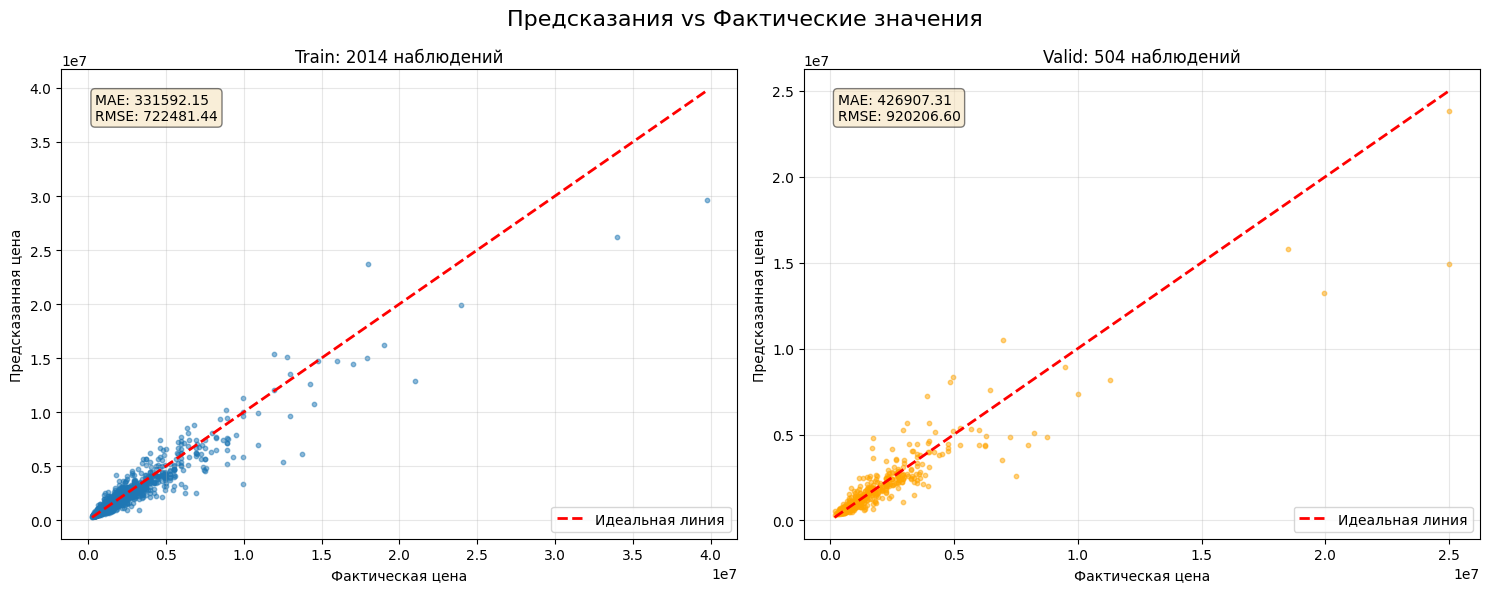

In [47]:
dtrain_for_pred = xgb.DMatrix(X_train_transformed)
y_train_pred_log = model.predict(dtrain_for_pred)
y_train_pred_original = np.expm1(y_train_pred_log)
y_train_original = np.expm1(y_train_log)
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes[0].scatter(y_train_original, y_train_pred_original, alpha=0.5, s=10)
axes[0].plot([y_train_original.min(), y_train_original.max()],
             [y_train_original.min(), y_train_original.max()],
             'r--', lw=2, label='Идеальная линия')
axes[0].set_xlabel('Фактическая цена')
axes[0].set_ylabel('Предсказанная цена')
axes[0].set_title(f'Train: {len(y_train_original)} наблюдений')
axes[0].grid(True, alpha=0.3)
axes[0].legend()
train_errors = y_train_original - y_train_pred_original
axes[0].text(0.05, 0.95, f'MAE: {mean_absolute_error(y_train_original, y_train_pred_original):.2f}\n'
                         f'RMSE: {np.sqrt(mean_squared_error(y_train_original, y_train_pred_original)):.2f}',
             transform=axes[0].transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
axes[1].scatter(y_true_original, y_pred_original, alpha=0.5, s=10, color='orange')
axes[1].plot([y_true_original.min(), y_true_original.max()],
             [y_true_original.min(), y_true_original.max()],
             'r--', lw=2, label='Идеальная линия')
axes[1].set_xlabel('Фактическая цена')
axes[1].set_ylabel('Предсказанная цена')
axes[1].set_title(f'Valid: {len(y_true_original)} наблюдений')
axes[1].grid(True, alpha=0.3)
axes[1].legend()
valid_errors = y_true_original - y_pred_original
axes[1].text(0.05, 0.95, f'MAE: {mae:.2f}\nRMSE: {rmse_original:.2f}',
             transform=axes[1].transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle('Предсказания vs Фактические значения', fontsize=16)
plt.tight_layout()
plt.show()

# **LightGBM**

In [48]:
import lightgbm as lgb
from lightgbm import LGBMRegressor

In [49]:
import numpy as np
import random
seed = 243
np.random.seed(seed)
random.seed(seed)

In [50]:
imputer = SimpleImputer(strategy='most_frequent')
df['Location'] = imputer.fit_transform(df[['Location']]).flatten()

In [51]:
scaler = StandardScaler()
one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=True)

In [52]:
X = df.drop('Price', axis=1)
y = df['Price']

In [53]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2,random_state=243, shuffle=True)

In [54]:
y_train_log = np.log1p(y_train)
y_valid_log = np.log1p(y_valid)

In [55]:
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
object_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

print("Числовые колонки:", numerical_cols)
print("Категориальные колонки:", object_cols)

Числовые колонки: ['Area_in_sq_ft', 'all_rooms']
Категориальные колонки: ['Property Name', 'House Type', 'Location', 'City/County']


In [56]:
categorical_features = Pipeline(steps=[
    ('imputer', imputer),
    ('ohe', one_hot_encoder)])

numerical_features = Pipeline(steps=[
    ('scaler', StandardScaler())])

columnTransformer = ColumnTransformer(transformers=[
    ('num', numerical_features, numerical_cols),
    ('cat', categorical_features, object_cols)])

In [57]:
X_train_transformed = columnTransformer.fit_transform(X_train)
X_valid_transformed = columnTransformer.transform(X_valid)

In [58]:
train_data = lgb.Dataset(X_train_transformed, label=y_train_log)
valid_data = lgb.Dataset(X_valid_transformed, label=y_valid_log, reference=train_data)

In [59]:
def objective(trial):
    params = {
        'boosting_type': 'gbdt',
        'num_iterations': trial.suggest_int('num_iterations', 100, 500), # аналог n_estimators
        'objective': 'regression',
        'max_depth': trial.suggest_int('max_depth', 2, 6),
        'num_leaves': trial.suggest_int('num_leaves', 2, 50),
        'min_split_gain': trial.suggest_float('min_split_gain', 0, 0.1),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.05, log=True),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.1, 1.0), # предотвращает переобучение
        'random_state': 243,
        'metric': 'rmse',
        'n_jobs': -1,
        'verbose': -1
    }

    model = lgb.train(
        params,
        train_data,
        num_boost_round=params['num_iterations'],
        valid_sets=[valid_data],
        callbacks=[
            lgb.early_stopping(stopping_rounds=20, verbose=False),
            lgb.log_evaluation(period=0)
        ]
    )

    best_score = model.best_score['valid_0']['rmse']
    return best_score

study_lgb = optuna.create_study(direction='minimize')
study_lgb.optimize(objective, n_trials=20, show_progress_bar=True)
print("Лучшие параметры:", study_lgb.best_params)
print(f"Лучший RMSE: {study_lgb.best_value:.6f}")

[I 2026-01-20 12:55:42,757] A new study created in memory with name: no-name-7bcf48ad-65aa-400a-90d0-c46fc19e1f9e


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2026-01-20 12:55:42,876] Trial 0 finished with value: 0.3791944341984419 and parameters: {'num_iterations': 478, 'max_depth': 3, 'num_leaves': 2, 'min_split_gain': 0.03490679862491736, 'learning_rate': 0.03796210778148196, 'bagging_fraction': 0.4993354876678805}. Best is trial 0 with value: 0.3791944341984419.
[I 2026-01-20 12:55:43,033] Trial 1 finished with value: 0.34274180882008554 and parameters: {'num_iterations': 348, 'max_depth': 5, 'num_leaves': 13, 'min_split_gain': 0.0006344109708739999, 'learning_rate': 0.016221414571464875, 'bagging_fraction': 0.2598409207348017}. Best is trial 1 with value: 0.34274180882008554.
[I 2026-01-20 12:55:43,099] Trial 2 finished with value: 0.37226780214553185 and parameters: {'num_iterations': 107, 'max_depth': 4, 'num_leaves': 41, 'min_split_gain': 0.0871936546522755, 'learning_rate': 0.023835047768674948, 'bagging_fraction': 0.5144071420217972}. Best is trial 1 with value: 0.34274180882008554.
[I 2026-01-20 12:55:43,162] Trial 3 finished w

In [60]:
print("Лучшие параметры:", study_lgb.best_params)
print(f"Лучший RMSE: {study_lgb.best_value:.6f}")

Лучшие параметры: {'num_iterations': 480, 'max_depth': 4, 'num_leaves': 26, 'min_split_gain': 0.04129741028179054, 'learning_rate': 0.037744506521670815, 'bagging_fraction': 0.47862607627299714}
Лучший RMSE: 0.333177


In [61]:
optuna.visualization.plot_edf(study_lgb, target=None, target_name='Price')

In [62]:
optuna.visualization.plot_optimization_history(study_lgb)

In [63]:
print("Лучшие параметры:", study_lgb.best_params)
print(f"Лучший RMSE (neg): {study_lgb.best_value:.6f}")
print(f"Лучший RMSE (pos): {-study_lgb.best_value:.6f}")

Лучшие параметры: {'num_iterations': 480, 'max_depth': 4, 'num_leaves': 26, 'min_split_gain': 0.04129741028179054, 'learning_rate': 0.037744506521670815, 'bagging_fraction': 0.47862607627299714}
Лучший RMSE (neg): 0.333177
Лучший RMSE (pos): -0.333177


In [64]:
#best_params = study_lgb.best_params

In [65]:
X_train_transformed = columnTransformer.fit_transform(X_train)
X_valid_transformed = columnTransformer.transform(X_valid)
train_data = lgb.Dataset(X_train_transformed, label=y_train_log)
valid_data = lgb.Dataset(X_valid_transformed, label=y_valid_log, reference=train_data)

params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'num_iterations': 425,
    'max_depth': 5,
    'metric': 'rmse',
    'min_split_gain':  0.003623627441294415,
    'boosting_type': 'gbdt',
    'num_leaves': 15,
    'learning_rate': 0.033708794149056344,
    'bagging_fraction': 0.7734850173595945,
    'verbosity': -1,
    'seed': 243,
    'n_jobs': -1,
    'verbose': -1
}

In [66]:
print("Обучение модели через lgb.train()...")
model = lgb.train(
    params,
    train_data,
    num_boost_round=params['num_iterations'],
    valid_sets=[valid_data],
    callbacks=[
        lgb.early_stopping(stopping_rounds=20),
        lgb.log_evaluation(period=0)
    ]
)

Обучение модели через lgb.train()...
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[390]	valid_0's rmse: 0.330905


In [67]:
mae = mean_absolute_error(y_true_original, y_pred_original)
mape = mean_absolute_percentage_error(y_true_original, y_pred_original) * 100
rmse_original = np.sqrt(mean_squared_error(y_true_original, y_pred_original))
median_error = np.median(np.abs(y_true_original - y_pred_original))

print("Метрики в ценах:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse_original:.2f}")
print(f"MAPE: {mape:.1f}%")
print(f"Медианная ошибка: {median_error:.2f}")

Метрики в ценах:
MAE: 426907.31
RMSE: 920206.60
MAPE: 21.5%
Медианная ошибка: 174628.88


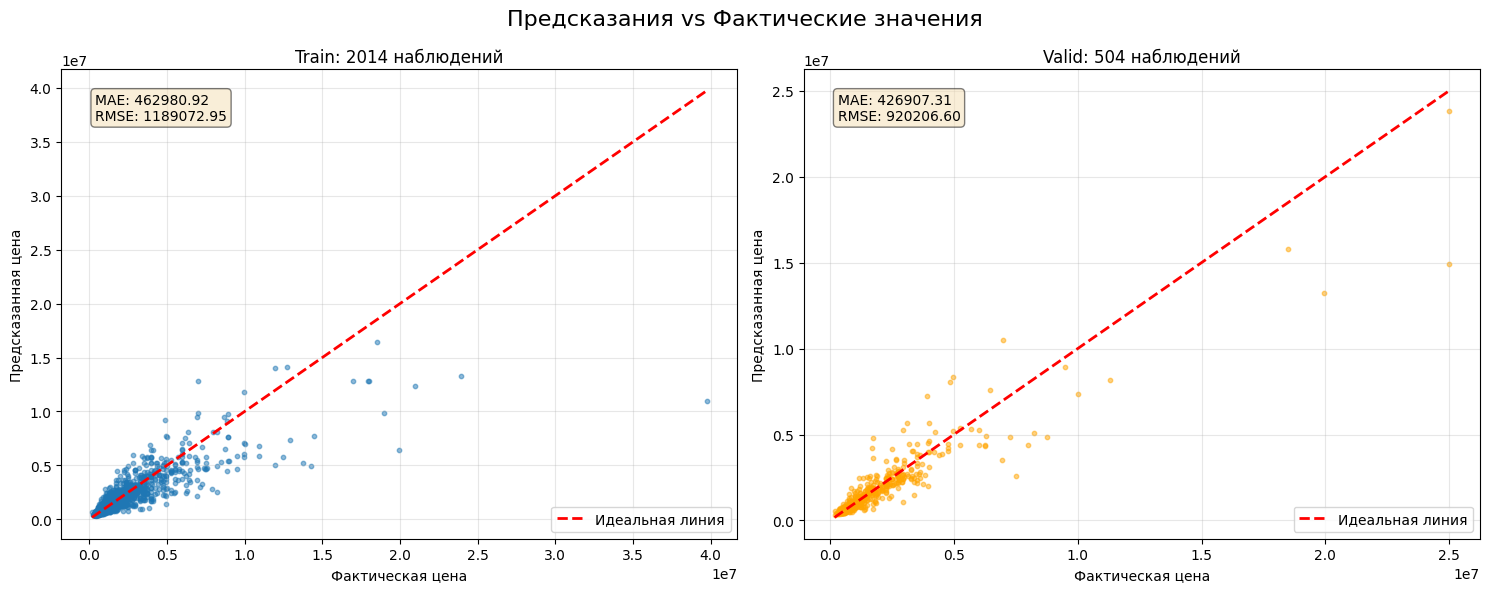

In [68]:
y_train_pred_log = model.predict(X_train_transformed)
y_train_pred_original = np.expm1(y_train_pred_log)
y_train_original = np.expm1(y_train_log)
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes[0].scatter(y_train_original, y_train_pred_original, alpha=0.5, s=10)
axes[0].plot([y_train_original.min(), y_train_original.max()],
             [y_train_original.min(), y_train_original.max()],
             'r--', lw=2, label='Идеальная линия')
axes[0].set_xlabel('Фактическая цена')
axes[0].set_ylabel('Предсказанная цена')
axes[0].set_title(f'Train: {len(y_train_original)} наблюдений')
axes[0].grid(True, alpha=0.3)
axes[0].legend()
train_errors = y_train_original - y_train_pred_original
axes[0].text(0.05, 0.95, f'MAE: {mean_absolute_error(y_train_original, y_train_pred_original):.2f}\n'
                         f'RMSE: {np.sqrt(mean_squared_error(y_train_original, y_train_pred_original)):.2f}',
             transform=axes[0].transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
axes[1].scatter(y_true_original, y_pred_original, alpha=0.5, s=10, color='orange')
axes[1].plot([y_true_original.min(), y_true_original.max()],
             [y_true_original.min(), y_true_original.max()],
             'r--', lw=2, label='Идеальная линия')
axes[1].set_xlabel('Фактическая цена')
axes[1].set_ylabel('Предсказанная цена')
axes[1].set_title(f'Valid: {len(y_true_original)} наблюдений')
axes[1].grid(True, alpha=0.3)
axes[1].legend()
valid_errors = y_true_original - y_pred_original
axes[1].text(0.05, 0.95, f'MAE: {mae:.2f}\nRMSE: {rmse_original:.2f}',
             transform=axes[1].transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle('Предсказания vs Фактические значения', fontsize=16)
plt.tight_layout()
plt.show()